# COVID-19 Open Research Dataset Challenge (CORD-19)
![](https://altaonline.typepad.com/.a/6a0192ac343706970d025d9b3673bb200c-800wi)

<h2>Goal</h2><br>
    This is my third response to the call to action to the artificial intelligence experts (if I can be called one) to develop text and data mining tools that can help the medical community develop answers to high priority scientific questions. For that I will use the CORD-19 dataset, which represents the most extensive machine-readable coronavirus literature collection available for data mining to date. Bellow are the current tasks for this challenge, which will be completed by the creation of a custer graph, a text classification for each cluster and a wordcloud for the main keywords for each cluster for the all_sources_metadata file. There are around 29500 papers in the dataset. These are listed in the all_sources_metadata file. Some of the papers in the metadata are also in JSON files. The eventual goal is to connect the metadata with the JSON data.<br>
    <h2>Tasks</h2>
    <ul>
    <li>What is known about transmission, incubation, and environmental stability?</li>
    <li>What do we know about COVID-19 risk factors?</li>
    <li>What do we know about virus genetics, origin, and evolution?</li>
    <li>Sample task with sample submission</li>
    <li>What do we know about vaccines and therapeutics?</li>
    <li>What do we know about non-pharmaceutical interventions?</li>
    <li>What has been published about ethical and social science considerations?</li>
    <li>What do we know about diagnostics and surveillance?</li>
    <li>What has been published about medical care?</li>
    <li>What has been published about information sharing and inter-sectoral collaboration?</li>
    </ul>
    <h2>Citations, ups and downs</h2><br>
    I tried to do this notebook by myself, which was terrifying. I was still looking forward to testing different NLP solutions (check my other ones <a href='https://www.kaggle.com/beatrizyumi/covid-19-autocomplete-search-bar'>here</a>  and here). I opted for the LDA, because it is easy to implement, has a visual output which is also easy to implement and it is possible to retrieve the main keywords and documents from each topic. On the plus side, you know exactly what each cluster is about, you get to see visualy the main keywords about each cluster, it is easy to implement. On the down side, I had zero experience with this sort of modeling and problem solving, which made the whole ordeal even longer to be solved, and depending on the size of the dataframe, it can take a while to load (mine took a few hours). Besides that I am still working on a way to split authors when they are separated by comma or by semicolon.<br>
    <h2>Features of this notebook</h2>
<ol><li>Viewing the papers in the metdata csv as a dataframe</li>
    <li>Viewing the papers separated by clusters in a graph</li>
    <li>Viewing the clusters listed and separated by topics</li>
    <li>Having a word cloud for each cluster with it's main keywords</li></ol>
    <h2>Turn your internet on!</h2><br>
    For this notebook to work your internet must be on.

# Importing libraries and datasets
![](https://media1.giphy.com/media/2yqYwtl5MUa6V405Ib/giphy.gif?cid=790b7611312b8226ba98603f316f4a2740c6e4a11ef228fc&rid=giphy.gif)

In [1]:
# Importing libraries

import sys
import os
from pathlib import Path
import re, numpy as np, pandas as pd
from pprint import pprint
import json
import glob

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

# NLTK Stop words
import nltk
from nltk.corpus import stopwords

#plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

In [2]:
#loading metadata file

metadata_path = 'metadata.csv'
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})
meta_df.head()

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file
0,NaN,Elsevier,Intrauterine virus infections and congenital h...,10.1016/0002-8703(72)90077-4,NaN,4361535,els-covid,Abstract The etiologic basis for the vast majo...,1972-12-31,"Overall, James C.",American Heart Journal,NaN,NaN,False,custom_license
1,NaN,Elsevier,Coronaviruses in Balkan nephritis,10.1016/0002-8703(80)90355-5,NaN,6243850,els-covid,NaN,1980-03-31,"Georgescu, Leonida; Diosi, Peter; Buţiu, Ioan;...",American Heart Journal,NaN,NaN,False,custom_license
2,NaN,Elsevier,Cigarette smoking and coronary heart disease: ...,10.1016/0002-8703(80)90356-7,NaN,7355701,els-covid,NaN,1980-03-31,"Friedman, Gary D",American Heart Journal,NaN,NaN,False,custom_license
3,aecbc613ebdab36753235197ffb4f35734b5ca63,Elsevier,Clinical and immunologic studies in identical ...,10.1016/0002-9343(73)90176-9,NaN,4579077,els-covid,"Abstract Middle-aged female identical twins, o...",1973-08-31,"Brunner, Carolyn M.; Horwitz, David A.; Shann,...",The American Journal of Medicine,NaN,NaN,True,custom_license
4,NaN,Elsevier,Epidemiology of community-acquired respiratory...,10.1016/0002-9343(85)90361-4,NaN,4014285,els-covid,Abstract Upper respiratory tract infections ar...,1985-06-28,"Garibaldi, Richard A.",The American Journal of Medicine,NaN,NaN,False,custom_license


In [3]:
# importing all json files

all_json = glob.glob(f'**/*.json', recursive=True)
len(all_json)

29315

# Treating the data
![](https://media2.giphy.com/media/l41YtBXZvSRdgqq7m/giphy.gif?cid=790b76115c16e4f50dc6c6525b7b74b67a0ef53415ae01c0&rid=giphy.gif)

First we create a class that will read the json files in a humane readable way.

In [4]:
# File Reader class

class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'

In [5]:
# Checking if the File Reader Class worked

print(FileReader(all_json[0]))

0015023cc06b5362d332b3baf348d11567ca2fbb: word count: 194 22 Text word count: 5168 23 24 25 author/funder. All rights reserved. No reuse allowed without permission. Abstract 27 The positive stranded RNA genomes of picornaviruses comprise a si... VP3, and VP0 (which is further processed to VP2 and VP4 during virus assembly) (6). The P2 64 and P3 regions encode the non-structural proteins 2B and 2C and 3A, 3B (1-3) (VPg), 3C pro and 4 structura...


In [6]:
# Function to add break every length characters

def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

We then input all the json files into a DataFrame. (This might take a while, since there are a lot of files). A lot of things will happen here.<br><br>
<b>First</b> we will only work with papers with meta data.<br><br>
<b>Second</b> if there is no abstract provided, we will use the title of the research paper as the abstract, as the analysis will use the abstract as a basis.<br><br>
<b>Third</b> all the other information is included on it's field, separated if there is more than one of each, in the case of authors, for example.


In [7]:
# Input the research papers into a DataFrame

dict_ = {'paper_id': [], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    content = FileReader(entry)
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    
    dict_['paper_id'].append(content.paper_id)
    dict_['abstract'].append(content.abstract)
    dict_['body_text'].append(content.body_text)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0: 
        # no abstract provided, we input the title
        dict_['abstract_summary'].append(meta_data['title'].values[0])
    else:
        dict_['abstract_summary'].append(content.abstract)
        
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    # if more than one author
    try:
        authors = str(meta_data['authors'].values[0]).split(';')
        authors1 = [i.split(',') for i in authors]    
        dict_['authors'].append(". ".join(authors))
    except Exception as e:
        dict_['authors'].append(". ".join(authors))
    
    # add the title information, add breaks when needed
    dict_['title'].append(meta_data['title'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

Processing index: 0 of 29315
Processing index: 2931 of 29315
Processing index: 5862 of 29315
Processing index: 8793 of 29315
Processing index: 11724 of 29315
Processing index: 14655 of 29315
Processing index: 17586 of 29315
Processing index: 20517 of 29315
Processing index: 23448 of 29315
Processing index: 26379 of 29315
Processing index: 29310 of 29315


,paper_id,abstract,body_text,authors,title,journal,abstract_summary
0,0015023cc06b5362d332b3baf348d11567ca2fbb,word count: 194 22 Text word count: 5168 23 24...,"VP3, and VP0 (which is further processed to VP...","Ward, J. C. J.. Lasecka-Dykes, L.. Neil, C.....",The RNA pseudoknots in foot-and-mouth disease ...,NaN,word count: 194 22 Text word count: 5168 23 24...
1,004f0f8bb66cf446678dc13cf2701feec4f36d76,,The 2019-nCoV epidemic has spread across China...,Hanchu Zhou. Jianan Yang. Kaichen Tang. Qin...,Healthcare-resource-adjusted vulnerabilities t...,NaN,Healthcare-resource-adjusted vulnerabilities t...
2,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,Infectious bronchitis (IB) causes significant ...,"Infectious bronchitis (IB), which is caused by...","Butt, S. L.. Erwood, E. C.. Zhang, J.. Sell...","Real-time, MinION-based, amplicon sequencing f...",NaN,Infectious bronchitis (IB) causes significant ...
3,0139ea4ca580af99b602c6435368e7fdbefacb03,Nipah Virus (NiV) came into limelight recently...,Nipah is an infectious negative-sense single-s...,Nishi Kumari. Ayush Upadhyay. Kishan Kalia. ...,A Combined Evidence Approach to Prioritize Nip...,NaN,Nipah Virus (NiV) came into limelight recently...
4,013d9d1cba8a54d5d3718c229b812d7cf91b6c89,Background: A novel coronavirus (2019-nCoV) em...,"In December 2019, a cluster of patients with p...",Shengjie Lai. Isaac Bogoch. Nick Ruktanoncha...,Assessing spread risk of Wuhan novel coronavir...,NaN,Background: A novel coronavirus (2019-nCoV) em...


In [8]:
dict_ = None

In [9]:
# Adding word count column

df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))
df_covid.head()

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count
0,0015023cc06b5362d332b3baf348d11567ca2fbb,word count: 194 22 Text word count: 5168 23 24...,"VP3, and VP0 (which is further processed to VP...","Ward, J. C. J.. Lasecka-Dykes, L.. Neil, C.....",The RNA pseudoknots in foot-and-mouth disease ...,NaN,word count: 194 22 Text word count: 5168 23 24...,241,1728
1,004f0f8bb66cf446678dc13cf2701feec4f36d76,,The 2019-nCoV epidemic has spread across China...,Hanchu Zhou. Jianan Yang. Kaichen Tang. Qin...,Healthcare-resource-adjusted vulnerabilities t...,NaN,Healthcare-resource-adjusted vulnerabilities t...,0,755
2,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,Infectious bronchitis (IB) causes significant ...,"Infectious bronchitis (IB), which is caused by...","Butt, S. L.. Erwood, E. C.. Zhang, J.. Sell...","Real-time, MinION-based, amplicon sequencing f...",NaN,Infectious bronchitis (IB) causes significant ...,1647,4003
3,0139ea4ca580af99b602c6435368e7fdbefacb03,Nipah Virus (NiV) came into limelight recently...,Nipah is an infectious negative-sense single-s...,Nishi Kumari. Ayush Upadhyay. Kishan Kalia. ...,A Combined Evidence Approach to Prioritize Nip...,NaN,Nipah Virus (NiV) came into limelight recently...,326,2399
4,013d9d1cba8a54d5d3718c229b812d7cf91b6c89,Background: A novel coronavirus (2019-nCoV) em...,"In December 2019, a cluster of patients with p...",Shengjie Lai. Isaac Bogoch. Nick Ruktanoncha...,Assessing spread risk of Wuhan novel coronavir...,NaN,Background: A novel coronavirus (2019-nCoV) em...,22,4642


There may be papers that were inputted from more than one source, so we should check and remove duplicated inputs.

In [10]:
# We will remove the duplicated papers
df_covid.shape

(27678, 9)

In [11]:
# Removing duplicated papers

duplicate_paper = ~(df_covid.title.isnull() | df_covid.abstract.isnull()) & (df_covid.duplicated(subset=['title', 'abstract']))
df_covid = df_covid[~duplicate_paper].reset_index(drop=True)
df_covid.shape

(27425, 9)

We will now start treating the text inside the DataFrame. Before doing anything, we have to define a lot of functions to do that.

In [12]:
# Creating a function that cleans text of special characters

def strip_characters(text):
    t = re.sub('\(|\)|:|,|;|\.|’|”|“|\?|%|>|<', '', text)
    t = re.sub('/', ' ', t)
    t = t.replace("'",'')
    return t

<>:4: DeprecationWarning: invalid escape sequence \(
<>:4: DeprecationWarning: invalid escape sequence \(
<>:4: DeprecationWarning: invalid escape sequence \(
<ipython-input-12-b498eeac4b3b>:4: DeprecationWarning: invalid escape sequence \(
  t = re.sub('\(|\)|:|,|;|\.|’|”|“|\?|%|>|<', '', text)


In [13]:
# Creating a function that makes text lowercase and uses the function created above

def clean(text):
    t = text.lower()
    t = strip_characters(t)
    return t

In [14]:
# Tokenize into individual tokens - words mostly

def tokenize(text):
    words = nltk.word_tokenize(text)
    return list(set([word for word in words 
                     if len(word) > 1
                     and not (word.isnumeric() and len(word) is not 4)
                     and (not word.isnumeric() or word.isalpha())] )
               )

In [15]:
# Creating a function that cleans and tokenize texts

def preprocess(text):
    t = clean(text)
    tokens = tokenize(t)
    return tokens

We will now tokenize the abstract and transform the output into a list.

In [16]:
# Preprocessing all the strings inside the column abstract. It will clean them, make them lower case and tokenize them.

df_covid['abstract_processed'] = df_covid['abstract'].apply(lambda x: preprocess(x))

In [17]:
# Transforming abstract_processed into a list

abstract = list(df_covid['abstract_processed'])
print(abstract[:1])

[['pks', 'hydroxyl', 'element', 'their', 'of', 'showed', 'analysis', '2′', 'poly-c-tract', 'one', 'replication', 'which', 'no', 'structural', 'word', 'confirmed', 'investigated', 'in', 'competitive', 'they', 'foot-and-mouth', 'site', 'open', 'untranslated', 'function', 'containing', 'signals', 'contribution', 'nucleotide', 'packaging', 'from', 'reuse', 'comprise', 'terminal', 'two', 'variable', 'advantage', 'provide', 'genomes', 'large', 'picornaviruses', '5′', 'well', '100-200', 'count', 'pk', 'has', 'utr', 'abstract', 'genome', 'kb', 'predicted', 'ribosome', 'text', 'however', 'rescued', 'although', 'that', 'is', 'selective', 'facilitates', 'competent', 'internal', 'report', 'include', 'reading', 'experiments', 'essential', 'virus', 'initiation', 'allowed', 'repeated', 'putative', 'were', 'frame', 'series', 'disease', 'structures', 'approximately', 'flanked', 'replicons', 'shape', 'analysed', 'region', 'earlier', 'reserved', 'for', 'than', 'the', 'all', 'primer', 'five', 'cre', 'with

We will now create a bigram and a trigram models and lemmetize.

In [18]:
# Build the bigram and trigram models

bigram = gensim.models.Phrases(abstract, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram = gensim.models.Phrases(bigram[abstract], threshold=100)  
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [19]:
# Creating a list of stopwords in english

stop_words = list(set(stopwords.words('english')))
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

In [20]:
# Creating a function that will remove stopwords, form bigrams, form tigrams and lemmatize

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

In [21]:
# Processing the abstract

abstract_processed = process_words(abstract)

# It is time for some modeling
![](https://media0.giphy.com/media/Mvm1XBC8O48EM/giphy.gif?cid=790b76119bdd3e0bcedc198f7b26c76abecbb392aba651cf&rid=giphy.gif)

But first let's create a dictionary and a corpus

In [22]:
# Creating the dictionary

id2word = corpora.Dictionary(abstract_processed)

In [23]:
# Create Corpus: Term Document Frequency

corpus = [id2word.doc2bow(text) for text in abstract_processed]

In [24]:
from gensim.models.ldamulticore import LdaMulticore

In [25]:
lda = LdaMulticore(corpus, id2word=id2word, num_topics=26)

In [26]:
# Defining the best number of topics for the LDA model

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus, id2word=id2word, num_topics=26)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [27]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=abstract_processed, start=2, limit=100, step=6)

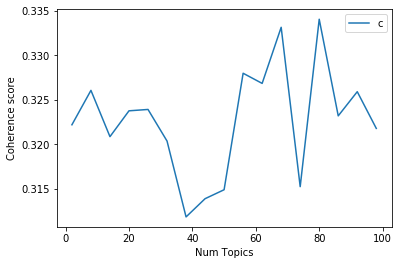

In [28]:
# Show graph
limit=100; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [29]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3222
Num Topics = 8  has Coherence Value of 0.3261
Num Topics = 14  has Coherence Value of 0.3209
Num Topics = 20  has Coherence Value of 0.3238
Num Topics = 26  has Coherence Value of 0.3239
Num Topics = 32  has Coherence Value of 0.3204
Num Topics = 38  has Coherence Value of 0.3118
Num Topics = 44  has Coherence Value of 0.3139
Num Topics = 50  has Coherence Value of 0.3149
Num Topics = 56  has Coherence Value of 0.328
Num Topics = 62  has Coherence Value of 0.3268
Num Topics = 68  has Coherence Value of 0.3331
Num Topics = 74  has Coherence Value of 0.3152
Num Topics = 80  has Coherence Value of 0.334
Num Topics = 86  has Coherence Value of 0.3232
Num Topics = 92  has Coherence Value of 0.3259
Num Topics = 98  has Coherence Value of 0.3218


The highest Coherence value was with 26 topics before flattening out, so we will go with 20.

In [30]:
# Build LDA model

lda_model = LdaMulticore(corpus=corpus,
                        id2word=id2word,
                        num_topics=20, 
                        random_state=42,
                        chunksize=150,
                        passes=30,
                        iterations = 500,
                        per_word_topics=True)

In [31]:
# Compute Perplexity (lower = better)

print('\nPerplexity: ', lda_model.log_perplexity(corpus))


Perplexity:  -8.849436114673859


In [32]:
# Compute Coherence Score

coherence_model_lda = CoherenceModel(model=lda_model, texts=abstract_processed, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.43186474143682874


In [33]:
# Visualize the topics

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.154364  0.027170       1        1  15.035303
2     -0.140383  0.166955       2        1  12.151147
3     -0.147124  0.048897       3        1   7.581241
6     -0.127748  0.159215       4        1   7.306941
0     -0.108850  0.011269       5        1   6.763011
19    -0.117646  0.028382       6        1   6.396780
13    -0.138941  0.034292       7        1   5.884457
17    -0.117818 -0.196950       8        1   5.849313
8     -0.078234 -0.166257       9        1   5.479456
5     -0.096748 -0.028618      10        1   5.267348
15    -0.108808 -0.068563      11        1   4.596170
14    -0.089384 -0.093810      12        1   4.035665
7      0.071969  0.128607      13        1   3.879297
11    -0.035126 -0.195419      14        1   2.422038
9      0.053233  0.204035      15        1   2.329597
1      0.178898  0.098085      16        1   2.142022
12     0.284245  0.081076      17        1   1.104788
18     0.233063 -0.210767      18        1   0.794228
4      0.316784 -0.021195      19        1   0.553917
16     0.322981 -0.006403      20        1   0.427283, topic_info=              Term          Freq         Total Category  logprob  loglift
351    respiratory   4414.000000   4414.000000  Default  30.0000  30.0000
641           cell  10398.000000  10398.000000  Default  29.0000  29.0000
88           virus  13814.000000  13814.000000  Default  28.0000  28.0000
668          acute   3170.000000   3170.000000  Default  27.0000  27.0000
498         severe   2877.000000   2877.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
989   coordination     50.059711     69.563995  Topic20  -4.9014   5.1264
5736      tolerate     51.133461     88.299812  Topic20  -4.8801   4.9092
1976        safety     69.634117    599.135559  Topic20  -4.5713   3.3032
2618   contributor     49.220383     88.733994  Topic20  -4.9183   4.8661
1349        unfold     48.442356    113.902969  Topic20  -4.9342   4.6005

[1322 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
3900      5  0.085548  abbreviation
3900     15  0.296362  abbreviation
3900     16  0.614112  abbreviation
1875      9  0.963200   abnormality
1875     11  0.031684   abnormality
...     ...       ...           ...
3594     10  0.065931         young
3594     11  0.133431         young
4181     10  0.180486          zone
4181     16  0.815797          zone
803      12  0.998219      zoonotic

[2962 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 3, 4, 7, 1, 20, 14, 18, 9, 6, 16, 15, 8, 12, 10, 2, 13, 19, 5, 17])

In [34]:
# Select the model and print the topics

optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(1,
  '0.006*"risk" + 0.005*"patient" + 0.005*"infection" + 0.005*"study" + '
  '0.005*"virus" + 0.005*"increase" + 0.004*"result" + 0.004*"health" + '
  '0.004*"high" + 0.004*"associate"'),
 (13,
  '0.011*"virus" + 0.010*"study" + 0.007*"infection" + 0.006*"result" + '
  '0.006*"cell" + 0.005*"viral" + 0.004*"identify" + 0.004*"sample" + '
  '0.004*"patient" + 0.004*"control"'),
 (10,
  '0.008*"sequence" + 0.006*"virus" + 0.005*"nucleotide" + 0.004*"study" + '
  '0.004*"genome" + 0.004*"gene" + 0.004*"result" + 0.004*"provide" + '
  '0.003*"base" + 0.003*"reaction"'),
 (20,
  '0.006*"study" + 0.006*"virus" + 0.005*"cell" + 0.005*"include" + '
  '0.005*"protein" + 0.004*"host" + 0.004*"show" + 0.004*"disease" + '
  '0.004*"system" + 0.004*"provide"'),
 (0,
  '0.014*"virus" + 0.011*"protein" + 0.010*"cell" + 0.007*"human" + '
  '0.006*"viral" + 0.006*"infection" + 0.005*"study" + 0.004*"bind" + '
  '0.004*"target" + 0.004*"show"'),
 (14,
  '0.008*"disease" + 0.007*"result" + 0.006*"stu

In [35]:
# Find the dominant topic in each sentence

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=abstract_processed):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [36]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=abstract_processed)

In [37]:
# Format

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [38]:
# Show

df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.7317,"virus, protein, cell, study, show, result, inf...","[show, analysis, replication, structural, word..."
1,1,0.0,0.0385,"virus, protein, cell, human, viral, infection,...",[]
2,2,25.0,0.5003,"virus, infection, result, study, test, detect,...","[express, protocol, building, spike, isolate, ..."
3,3,5.0,0.3688,"infection, cell, disease, result, virus, study...","[disease, study, simultaneously, feature, iden..."
4,4,2.0,0.8798,"analysis, sequence, virus, study, result, huma...","[end, novel, human, human, emerge, background,..."
5,5,14.0,0.5328,"disease, result, study, virus, health, method,...","[collect, gain, lead, human, efficiency, facto..."
6,6,0.0,0.9815,"virus, protein, cell, human, viral, infection,...","[constraint, study, human, antiviral, hijack, ..."
7,7,14.0,0.9753,"disease, result, study, virus, health, method,...","[specific, controversial, age, specific, reduc..."
8,8,16.0,0.7898,"virus, cell, study, result, show, infection, p...","[study, cell, method, efficiency, deliver, pos..."
9,9,0.0,0.0385,"virus, protein, cell, human, viral, infection,...",[]


In [39]:
df_dominant_topic.shape

(27425, 5)

In [40]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9954,"virus, protein, cell, human, viral, infection,...","[site, require, group, rps, functional, presen..."
1,1.0,0.9946,"risk, patient, infection, study, virus, increa...","[disease, review, cough, require, human, poten..."
2,2.0,0.9920,"analysis, sequence, virus, study, result, huma...","[group, method, thin, analysis, demonstrate, i..."
3,3.0,0.9956,"virus, protein, cell, study, show, result, inf...","[pioneer, nest, release, societal, isolate, eq..."
4,4.0,0.9919,"study, result, cell, protein, show, high, gene...","[work, method, rare, efficiency, urgently, exp..."
5,5.0,0.9917,"infection, cell, disease, result, virus, study...","[study, express, disease, morbidity, work, hum..."
6,6.0,0.9917,"cell, virus, study, receptor, infection, show,...","[multiple, analyze, receptor, bind, cell, prop..."
7,7.0,0.9904,"infection, study, result, virus, show, test, m...","[study, potentially, prevent, helpful, show, a..."
8,8.0,0.9900,"study, include, infection, patient, result, pr...","[study, antibody, study, finally, femoral, nec..."
9,9.0,0.9916,"study, virus, cell, protein, result, disease, ...","[phenomenon, identify, group, method, show, ex..."


In [41]:
# extracting keywords per topic

keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]
keywords.to_csv('keywords.csv')

In [61]:
all_keywords = keywords['Keywords'].values.tolist()
all_keywords = [i.split(',')[1] for i in all_keywords]
all_keywords_unique = keywords['Keywords'].unique().tolist()
count_keywords = len(all_keywords)
count_keywords_svg = keywords['Keywords'].nunique()

In [63]:
for i in all_keywords_unique:
    i.isin(all_keywords)

26

In [55]:
all_keywords

[' protein',
 ' patient',
 ' sequence',
 ' protein',
 ' result',
 ' cell',
 ' virus',
 ' study',
 ' include',
 ' virus',
 ' virus',
 ' virus',
 ' cell',
 ' study',
 ' result',
 ' disease',
 ' cell',
 ' infection',
 ' study',
 ' protein',
 ' virus',
 ' study',
 ' model',
 ' infection',
 ' infection',
 ' infection']

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

In [ ]:
# extracting dominant topics

df_dominant_topics.to_csv('topic_keyword_document.csv')

In [ ]:
# Creating word clouds for each topic

cols = [color for name, color in mcolors.XKCD_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()